<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square-Project/blob/master/Pratice/UNet_Pratice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.activations import softmax

import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# loss function definition
def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

<img src="https://i.imgur.com/NemXVrG.png" width="100%">

In [0]:
def UNet(level=4):
    x = Input(shape=(256, 256, 3))    # according to the paper
    inputs = x
    nKernels = 16   # according to the paper
    skip_layers = []     # for skip connection


    # downsampling
    x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)
    # (None, 256, 256, 16)
    for i in range(level-1):
        x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)
        # (None, 256, 256, 16)
        x = BatchNormalization()(x)
        x = Conv2D(nKernels*2, 3, activation='relu', padding='same')(x)
        # (None, 256, 256, 32)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        x = MaxPooling2D()(x)
        # (None, 128, 128, 32)
        nKernels = nKernels*2
    
    # nKernels: 128
    # x: (None, 32, 32, 128)

    # bottleneck
    x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 128
    # (None, 32, 32, 128)
    x = BatchNormalization()(x)
    x = Conv2D(nKernels*2, 3, activation='relu', padding='same')(x)   # 256
    # (None, 32, 32, 256)
    x = BatchNormalization()(x)
    x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 128
    # (None, 32, 32, 128)
    x = BatchNormalization()(x)   

    # nKernels: 128
    # x: (None, 32, 32, 128)

    # upsampling
    for i in range(level-1):
        x = UpSampling2D()(x)
        # (None, 64, 64, 128)
        x = Concatenate(axis=3)([x, skip_layers[::-1][i]])
        # (None, 64, 64, 256)
        x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 128
        # (None, 64, 64, 128)
        x = BatchNormalization()(x)
        x = Conv2D(nKernels//2, 3, activation='relu', padding='same')(x)   # 64
        # (None, 64, 64, 64)
        x = BatchNormalization()(x)
        nKernels = nKernels//2

    # x: (None, 256, 256, 32)
    
    x = Conv2D(200, 3, activation='relu', padding='same')(x)
    # x: (None, 256, 256, 200)
    x = BatchNormalization()(x)
    x = Conv2D(2, 1, activation='softmax', padding='same')(x)  # softmax
    # x: (None, 256, 256, 2)
    # x = BatchNormalization()(x) # is it right?
    outputs = x

    # model creation
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='rmsprop', loss=bce_dice_loss, metrics=[dice_coef])

    return model

In [0]:
model = UNet()

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 16) 64          conv2d_25[0][0]                  
______________________________________________________________________________________________

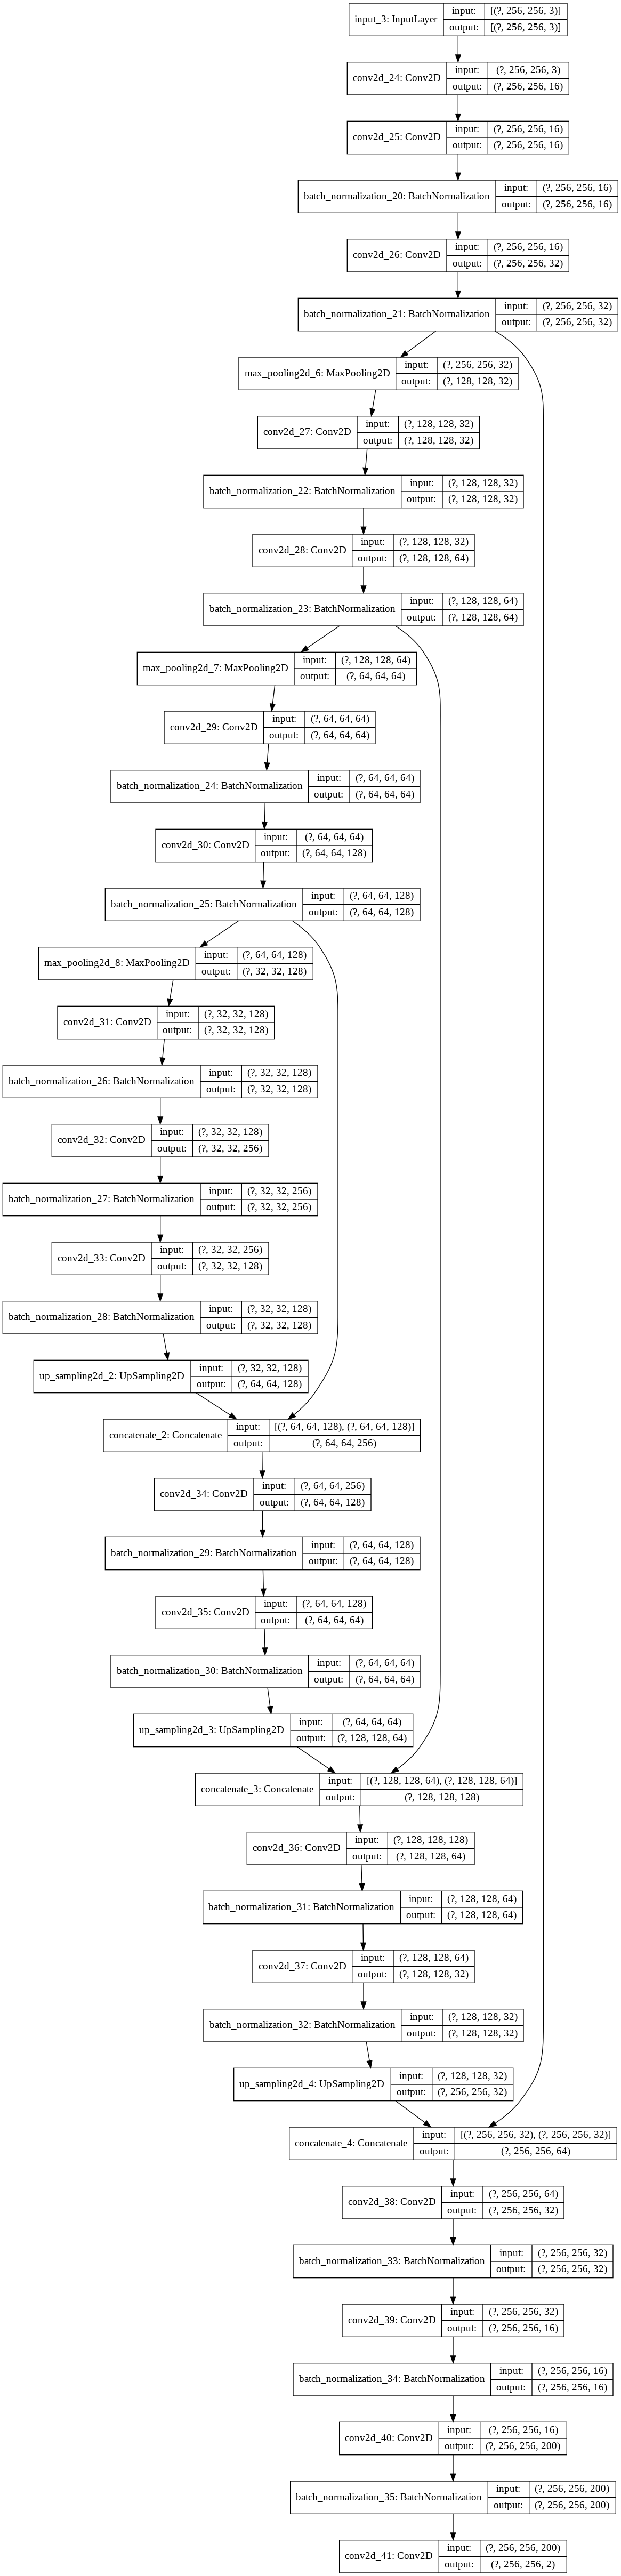

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True)